In [39]:
import yfinance
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns
import scipy.optimize as opt 
import datetime 
import time 
import scipy
from numba import jit
import warnings 
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller
from arch import arch_model 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import nbformat
import ruptures as rpt 
from pyod.models.iforest import IForest 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from functions import *
import statsmodels.api as sm 
pd.set_option('display.precision',4)
pd.set_option('display.float_format','{:,.4}'.format)
sns.set_style('darkgrid')
plt.rc('figure', figsize = (16,6))
plt.rc('font', family = 'sans-serif')


### Functions

In [40]:
def fontdict(fontsize=16, fontweight='bold'):
  return {'fontsize':fontsize, 'fontweight': fontweight}

def set_frame_style(df,caption=''):
  return df.style.background_gradient(cmap='Blues').set_caption(caption).set_table_styles([{'selector':'caption','props':[('color','White'),('font-size','16px'),('font-weight','bold'),('text-align','left')]}])

### Metrics

In [41]:
comparison_df = pd.DataFrame()
def concat_model(model, MSE, MAE, R_squared,comparison_df=comparison_df):
  comparison_df = pd.concat([comparison_df, pd.DataFrame([[f'{model}',MSE,MAE,R_squared]], columns=['Model','MSE','MAE','R_squared'])], axis=0,ignore_index=True)
  return comparison_df

def compute_metrics(actual, predicted):
  return (mean_squared_error(actual, predicted),
          mean_absolute_error(actual, predicted),
          r2_score(actual, predicted))




### Data

In [42]:
raw_data = yfinance.download(tickers='^GSPC', start='2009-04-06', end='2020-12-31')
stock = raw_data.copy()
display(set_frame_style(raw_data.head(5)))


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-04-06 00:00:00,839.750000,839.750000,822.789978,835.479980,835.479980,6210000000
2009-04-07 00:00:00,834.119995,834.119995,814.530029,815.549988,815.549988,5155580000
2009-04-08 00:00:00,816.760010,828.419983,814.840027,825.159973,825.159973,5938460000
2009-04-09 00:00:00,829.289978,856.909973,829.289978,856.559998,856.559998,7600710000
2009-04-13 00:00:00,855.330017,864.309998,845.349976,858.729980,858.729980,6434890000


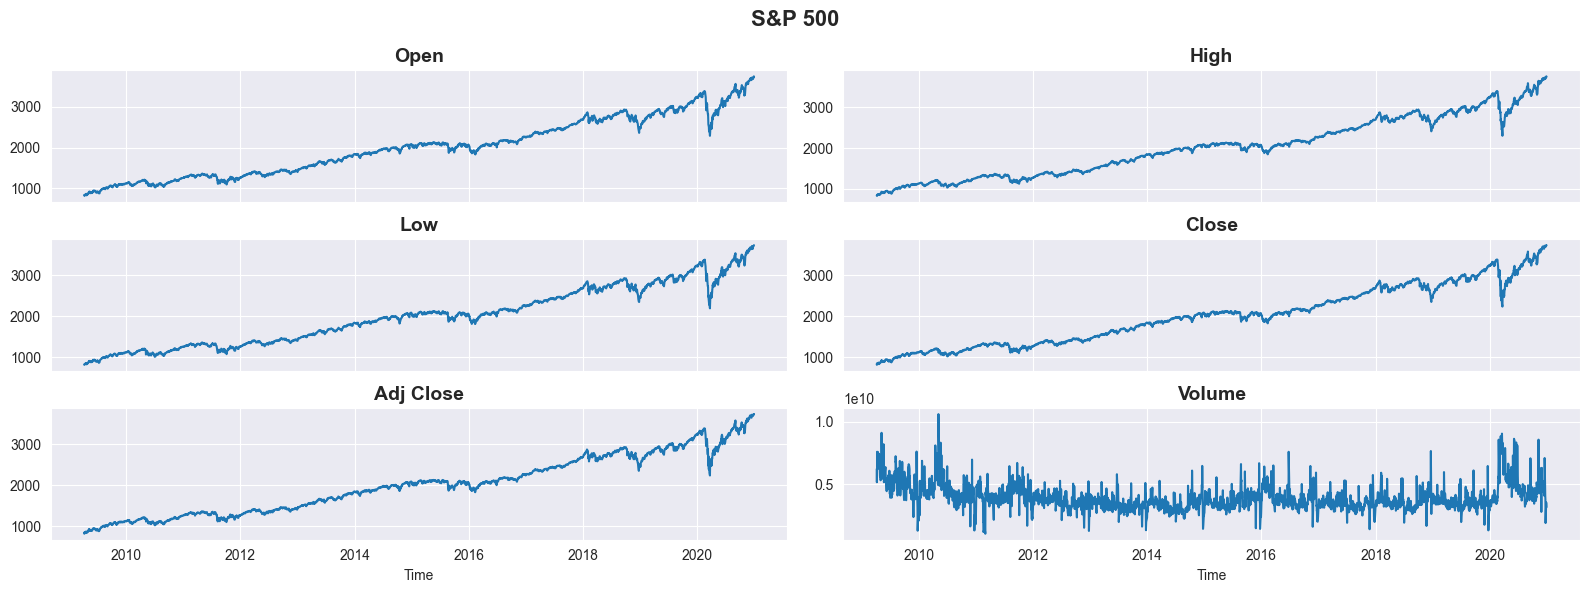

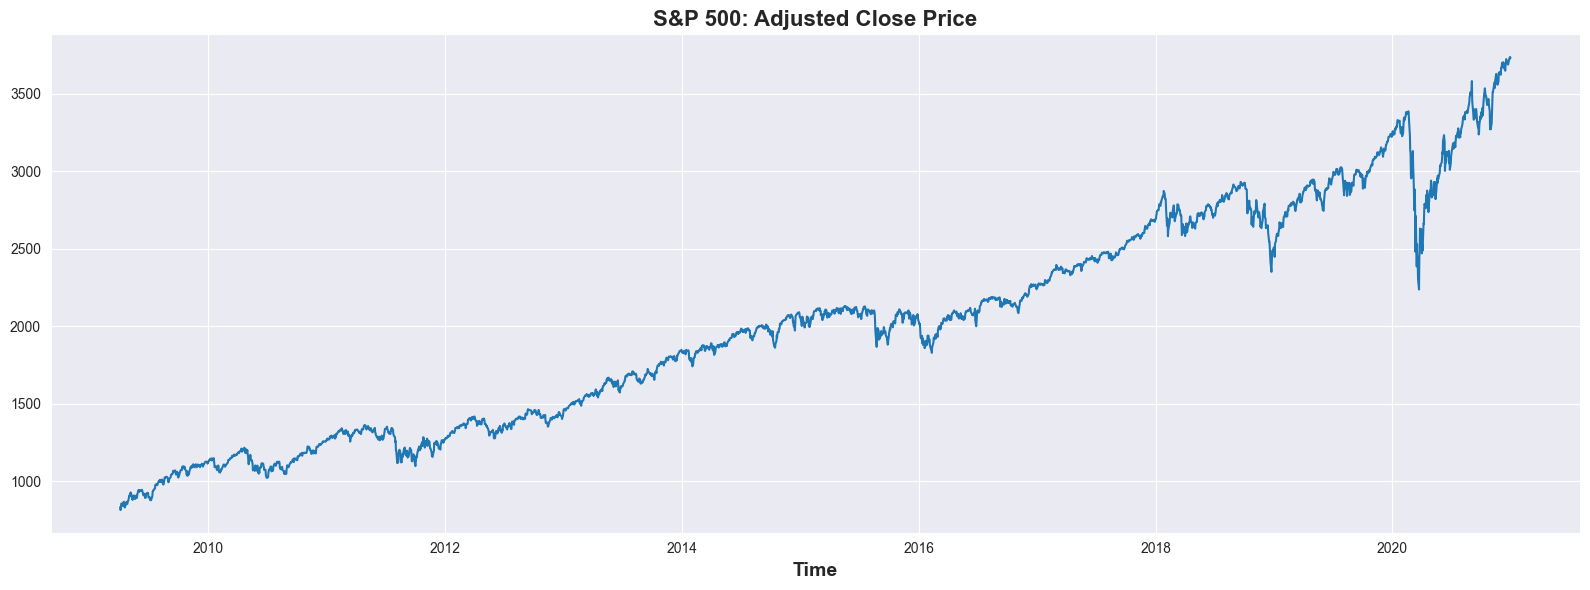

In [43]:
fig, axes = plt.subplots(3,2, sharex=True)
axes = axes.flatten()
for i, col in enumerate(stock.columns):
  sns.lineplot(data = stock[col],
               ax = axes[i],
               legend = False)
  axes[i].set_ylabel(None)
  axes[i].set_xlabel('Time')
  axes[i].set_title(f'{col}',fontdict=fontdict(14))
fig.suptitle("S&P 500", fontsize=16, fontweight='bold') 
plt.tight_layout()
plt.show()
plt.grid(True)
plt.plot(stock['Adj Close'])
plt.title('S&P 500: Adjusted Close Price', fontdict=fontdict(16))
plt.xlabel('Time', fontdict=fontdict(14))
plt.ylabel(None)
plt.tight_layout()
plt.show()


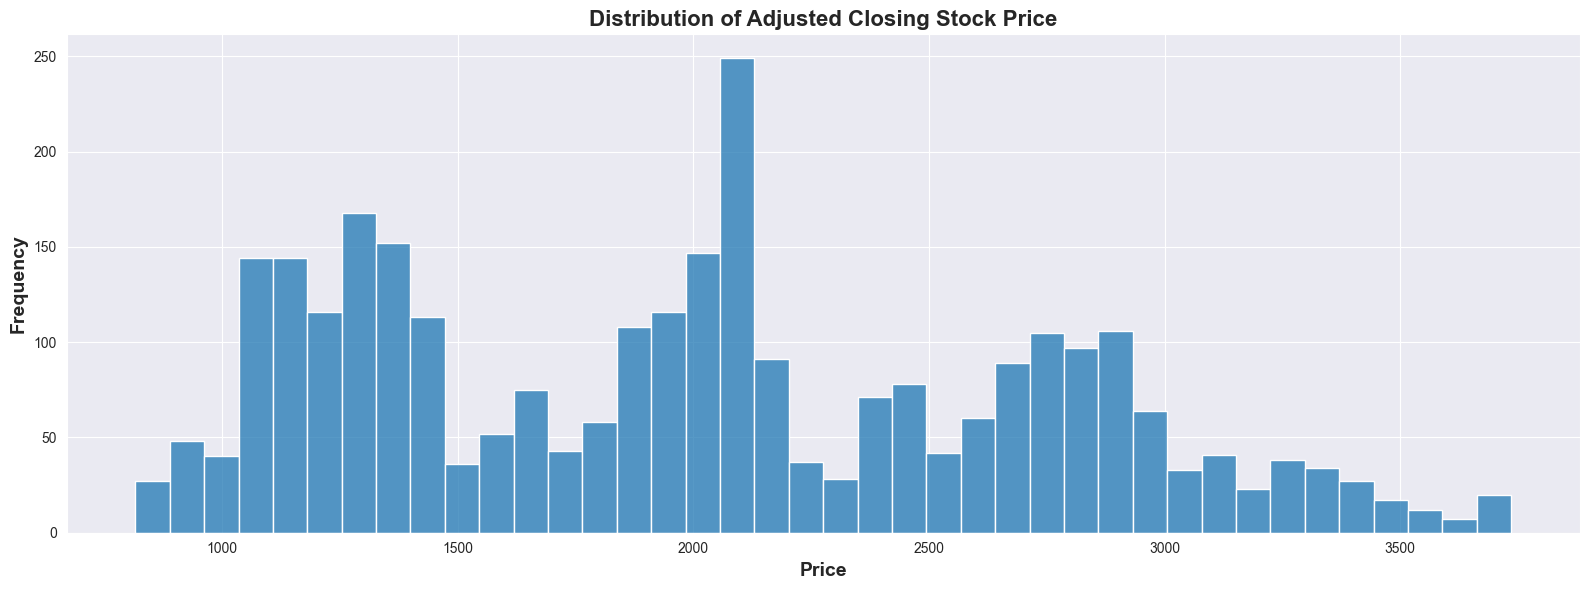

In [44]:
sns.histplot(stock['Adj Close'],bins=40)
plt.title('Distribution of Adjusted Closing Stock Price', fontdict=fontdict())
plt.xlabel('Price',fontdict=fontdict(14))
plt.ylabel('Frequency',fontdict=fontdict(14))
plt.tight_layout()
plt.show()

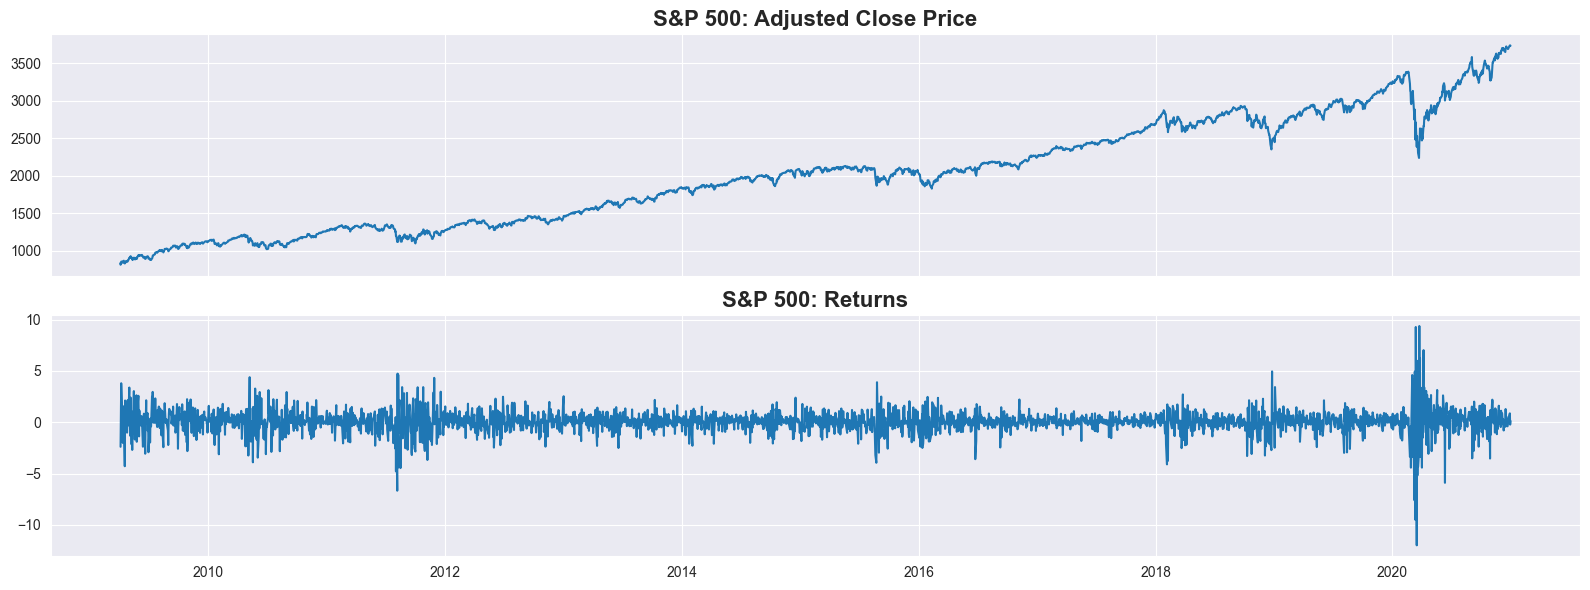

In [45]:
returns = 100 * (stock.pct_change()[1:]['Adj Close'])
stock = stock.dropna()

figure, axes = plt.subplots(2,1,sharex = True)

axes[0].plot(stock['Adj Close'])
axes[0].set_title('S&P 500: Adjusted Close Price', fontdict=fontdict())

axes[1].plot(returns)
axes[1].set_title('S&P 500: Returns', fontdict=fontdict())

plt.tight_layout()


### Square Returns
negative skewness means that the tail is more pronounced on the left rather than th right side. A negative skew may indicate that we can expect some small gains here and there. But we can be certain that a few large losses happen. Positive kurtosis (leptokurtosis) indicates heavy tails and a more peaked distribution compared to a normal distribution. Overall, the data appears fairly symmetrical and normally distributed ....

skewness: -0.5412004021938813
kurtosis: 13.69504925264588


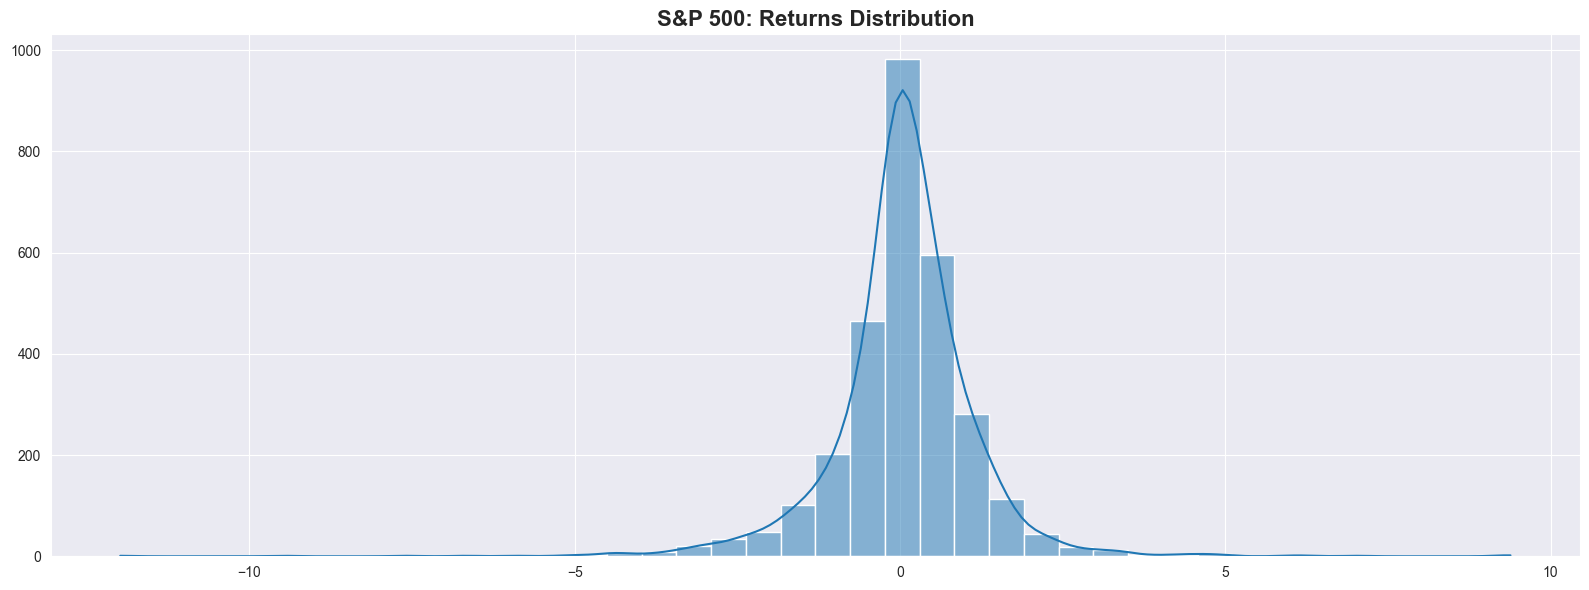

In [46]:
print('skewness:',scipy.stats.skew(returns,bias=True))
print('kurtosis:',scipy.stats.kurtosis(returns,bias=True))
sns.histplot(returns,kde=True,bins=40)
plt.title('S&P 500: Returns Distribution', fontdict=fontdict())
plt.xlabel(None)
plt.ylabel(None)
plt.tight_layout()


### BAsic Outliers Detecting

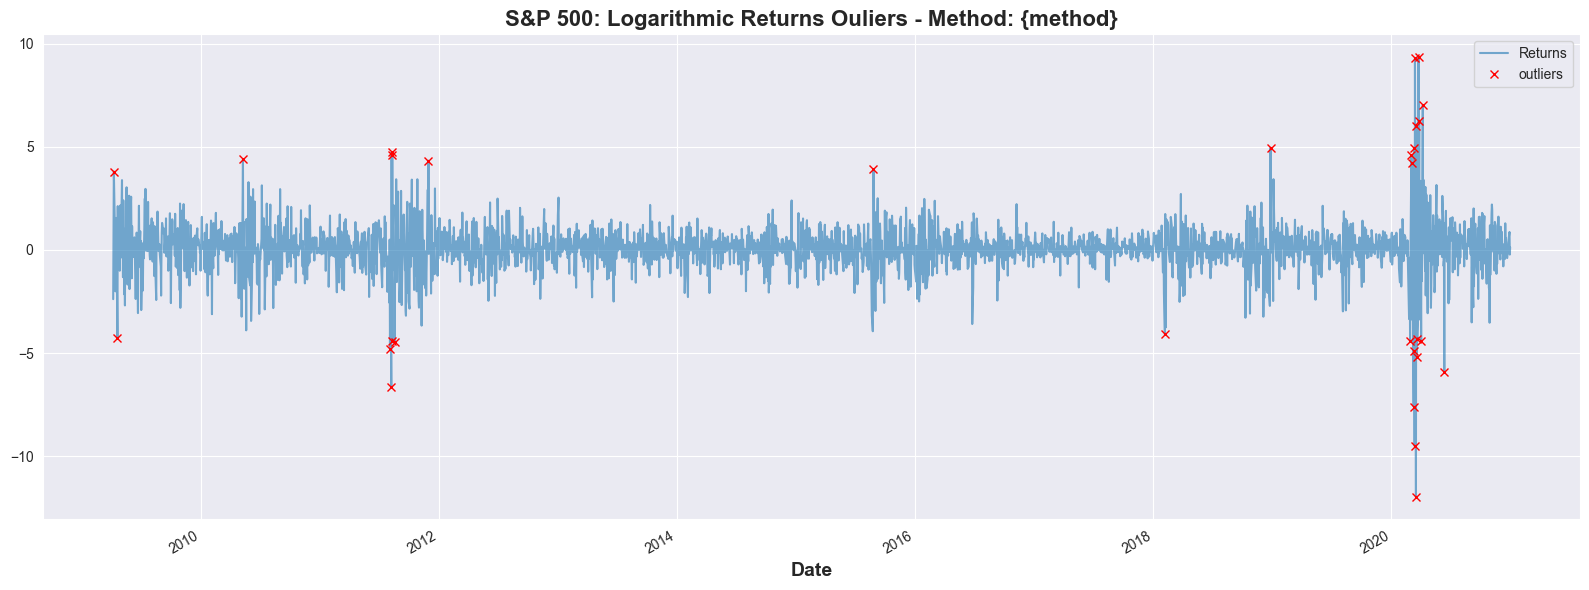

In [48]:
iforest = IForest(contamination=0.01, n_estimators=100,random_state=0)

# Fit the model to the data
iforest.fit(pd.DataFrame(returns))
predicted = pd.Series(iforest.predict(pd.DataFrame(returns)), index=pd.DataFrame(returns).index)
# Convert the predicted labels to a pandas Series (if needed)
outliers = predicted[predicted==1]
outliers = pd.DataFrame(returns).loc[outliers.index]
outliers.sum()
plot_outliers(outliers, returns,'IForest')

### Splitted Data

In [49]:
test_size = 365
train_size =  len(returns)-test_size
test_index = returns[-test_size:]
train_index = returns[:-test_size]
print('The size of the training data:',train_size)
print('The size of the testing data:', test_size)


The size of the training data: 2590
The size of the testing data: 365


In [50]:
### Realized Volatility
![image.png](attachment:image.png)

'[image.png]' is not recognized as an internal or external command,
operable program or batch file.


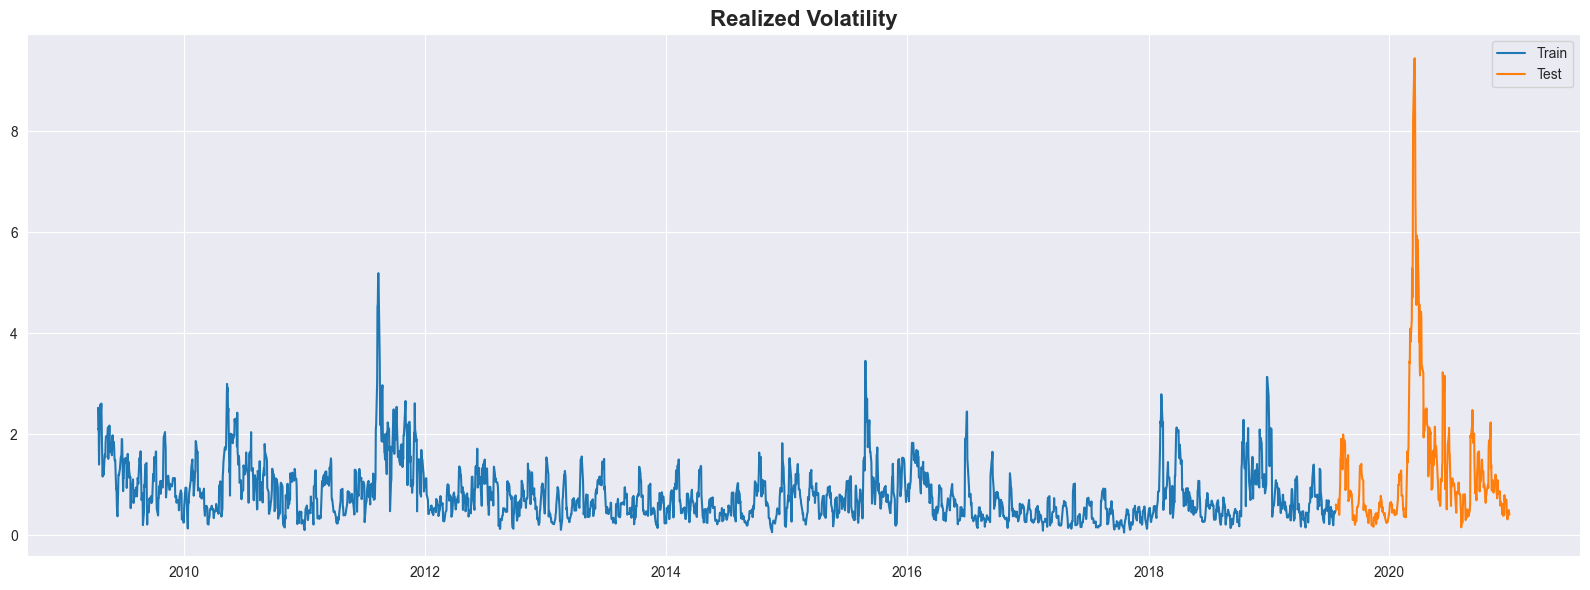

In [51]:
realized_vol = returns.rolling(5).std()

plt.title('Realized Volatility', fontdict=fontdict())
plt.plot(realized_vol[:-test_size])
plt.plot(realized_vol[-test_size:])
plt.legend(['Train', 'Test'], loc='best')
plt.tight_layout()
 

## Scaled Volatilty to fit Garch 

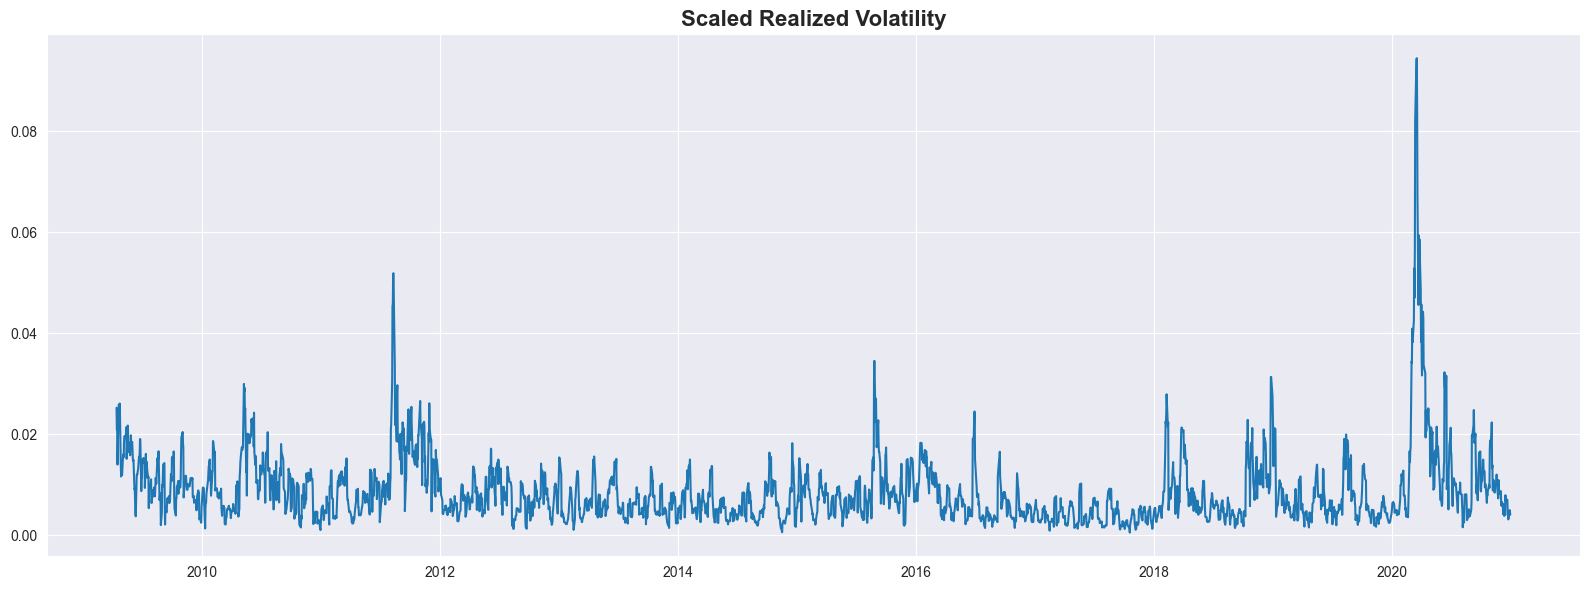

In [52]:
realized_vol_scaled = realized_vol/100
plt.plot(realized_vol_scaled)
plt.title('Scaled Realized Volatility', fontdict=fontdict())
plt.tight_layout()

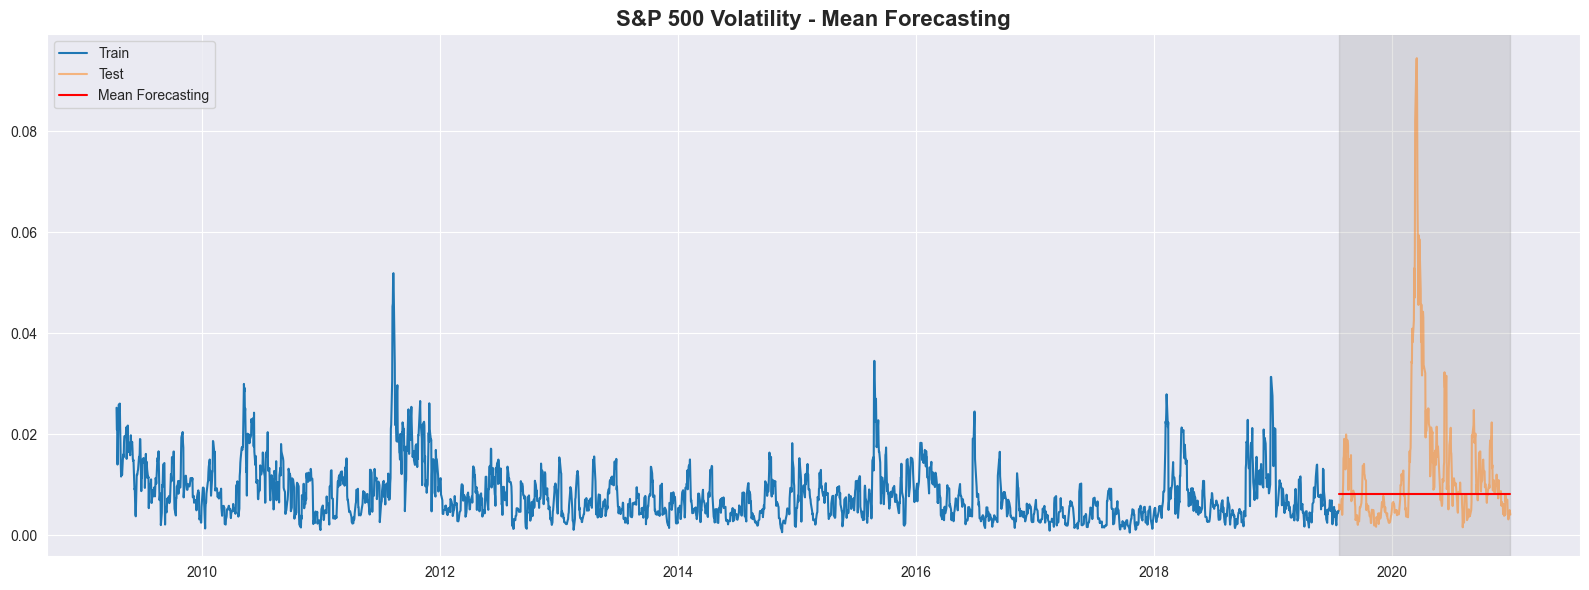

,Model,MSE,MAE,R_squared
0,Mean,0.000225,0.007867,0.000000


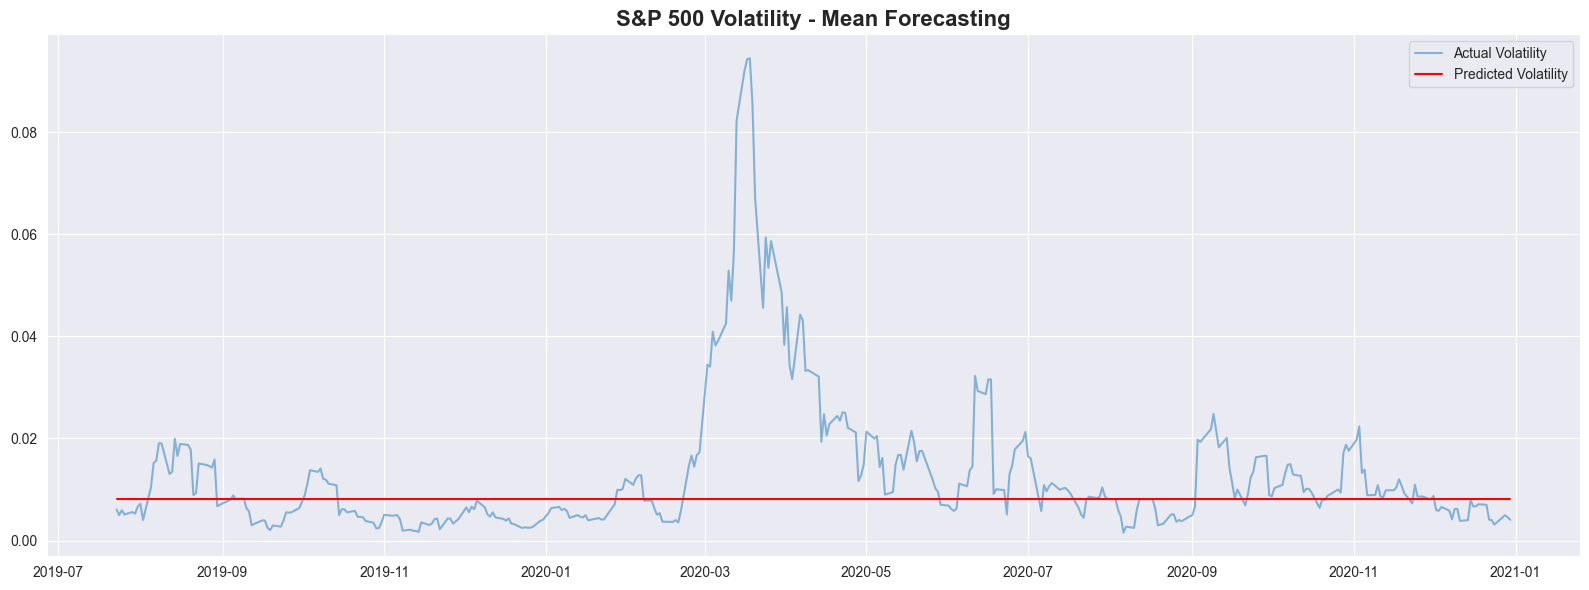

In [53]:
mean_train = np.mean(realized_vol_scaled[:-test_size])
mean_pred = pd.Series(np.full(shape=test_size, fill_value=mean_train, dtype='float'),index=realized_vol_scaled[-test_size:].index)

plt.plot(realized_vol_scaled[:-test_size])
plt.plot(realized_vol_scaled[-test_size:], alpha=0.5)
plt.plot(mean_pred, color='red')
plt.legend(['Train','Test', 'Mean Forecasting'])
plt.title('S&P 500 Volatility - Mean Forecasting', fontdict= fontdict())
plt.axvspan(realized_vol_scaled.index[train_size], realized_vol_scaled.index[-1], color='#808080', alpha=0.2)
plt.tight_layout()
plt.show()

MSE, MAE, R_squared = compute_metrics(mean_pred[-test_size:], realized_vol_scaled[-test_size:])
comparison_df=concat_model('Mean', MSE, MAE, R_squared)
display(set_frame_style(comparison_df))

plt.plot(realized_vol_scaled[-test_size:], alpha=0.5)
plt.plot(mean_pred, color='red')
plt.legend(['Actual Volatility', 'Predicted Volatility'])
plt.title('S&P 500 Volatility - Mean Forecasting', fontdict= fontdict() )
plt.tight_layout()

### Garch model
...
assumptions
arma ...
https://online.stat.psu.edu/stat510/lesson/11/11.1

In [54]:
is_stationary(returns)

'the time series is stationary'

the log return is stationary the squared shows the arma process -> garch
https://medium.com/@ooemma83/how-to-interpret-acf-and-pacf-plots-for-identifying-ar-ma-arma-or-arima-models-498717e815b6
we see the gradual decay in autocorrelation and significant spikes in the pacf
we see the spikes at 1,2 ,7, ..from pacf, so the degree will fall into such values, we can do the grid search to find the best one

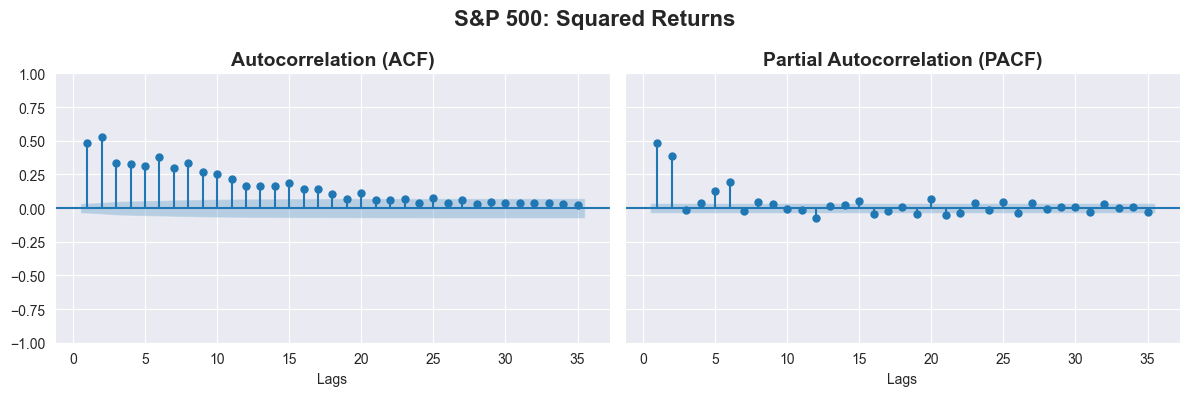

In [55]:
fig, (ax1,ax2) = plt.subplots(1,2,sharey=True, figsize =(12,4))

plot_acf(returns**2, zero=False, ax=ax1)
plot_pacf(returns**2, zero=False, ax=ax2)
fig.suptitle('S&P 500: Squared Returns', fontsize=16, fontweight='bold')
ax1.set_xlabel('Lags')
ax1.set_title('Autocorrelation (ACF)', fontdict = fontdict(14))
ax2.set_title('Partial Autocorrelation (PACF)', fontdict = fontdict(14))
ax2.set_xlabel('Lags')
plt.tight_layout()

![image.png](attachment:image.png)

In [56]:
best_aic = float('inf')
best_order = None
models_df = pd.DataFrame()
for p in range(1,7):  
    for q in range(1,7):
        model = arch_model(returns, vol='Garch', p=p, q=q)
        result = model.fit(disp='off')
        aic = result.aic

        if aic < best_aic:
            best_aic = aic
            best_order = (p, q)

        coef_table_df=pd.DataFrame(result.summary().tables[2])
        coef_table_cols = [str(cell) for cell in coef_table_df.loc[0].values]
        coef_table_df.columns=coef_table_cols
        coef_table_df = coef_table_df[1:]
        coef_table_df['P>|t|'] = coef_table_df['P>|t|'].astype(str).astype(float)
        count_significant_coeff = (coef_table_df['P>|t|']> 0.05).sum()
        models_df = pd.concat([models_df, pd.DataFrame({'order':[(p,q)],'aic':[(aic)],'Number of Insignificant Coefficients':[count_significant_coeff]})],ignore_index=True)
            
models_df.sort_values(by=['Number of Insignificant Coefficients','aic'],ignore_index=True).head(5)

,order,aic,Number of Insignificant Coefficients
0,"(1, 1)",7.537e+03,0
1,"(2, 2)",7.533e+03,1
2,"(2, 1)",7.534e+03,1
3,"(1, 2)",7.539e+03,1
4,"(3, 2)",7.535e+03,2


### Choices of Distributions
Financial returns are often heavy tailed, and a Students' T Distribution is one of the methods to capture this feature. Let's try different distribution (normal, students'T distribution and skew students'T distribution)out.

In [57]:
dists = ['normal','studentst', 'skewstudent']
for i,dist in enumerate(dists):
  model = arch_model(returns,dist=dist, vol = 'Garch', p=1, q=1, mean='Constant')
  result = model.fit(disp='off')
  table_summary = pd.DataFrame(result.summary().tables[0],columns=['Col_1', 'Value_1','Col_2','Value_2'])
  display(set_frame_style(table_summary,  f'Summary for {dist} distribution'))

,Col_1,Value_1,Col_2,Value_2
0,Dep. Variable:,Adj Close,R-squared:,0.000
1,Mean Model:,Constant Mean,Adj. R-squared:,0.000
2,Vol Model:,GARCH,Log-Likelihood:,-3764.59
3,Distribution:,Normal,AIC:,7537.18
4,Method:,Maximum Likelihood,BIC:,7561.14
5,,,No. Observations:,2955
6,Date:,"Thu, Mar 14 2024",Df Residuals:,2954
7,Time:,09:36:22,Df Model:,1


,Col_1,Value_1,Col_2,Value_2
0,Dep. Variable:,Adj Close,R-squared:,0.000
1,Mean Model:,Constant Mean,Adj. R-squared:,0.000
2,Vol Model:,GARCH,Log-Likelihood:,-3669.50
3,Distribution:,Standardized Student's t,AIC:,7349.00
4,Method:,Maximum Likelihood,BIC:,7378.95
5,,,No. Observations:,2955
6,Date:,"Thu, Mar 14 2024",Df Residuals:,2954
7,Time:,09:36:22,Df Model:,1


,Col_1,Value_1,Col_2,Value_2
0,Dep. Variable:,Adj Close,R-squared:,0.000
1,Mean Model:,Constant Mean,Adj. R-squared:,0.000
2,Vol Model:,GARCH,Log-Likelihood:,-3659.95
3,Distribution:,Standardized Skew Student's t,AIC:,7331.89
4,Method:,Maximum Likelihood,BIC:,7367.84
5,,,No. Observations:,2955
6,Date:,"Thu, Mar 14 2024",Df Residuals:,2954
7,Time:,09:36:22,Df Model:,1


Skew is the best one with the lowest AIC and highest log-likelihood

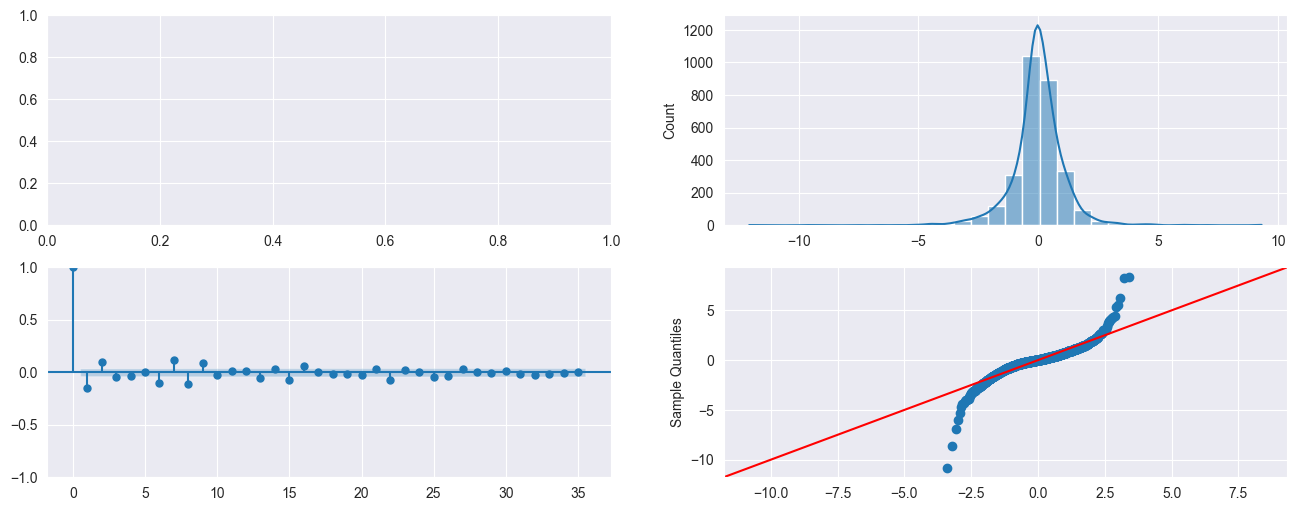

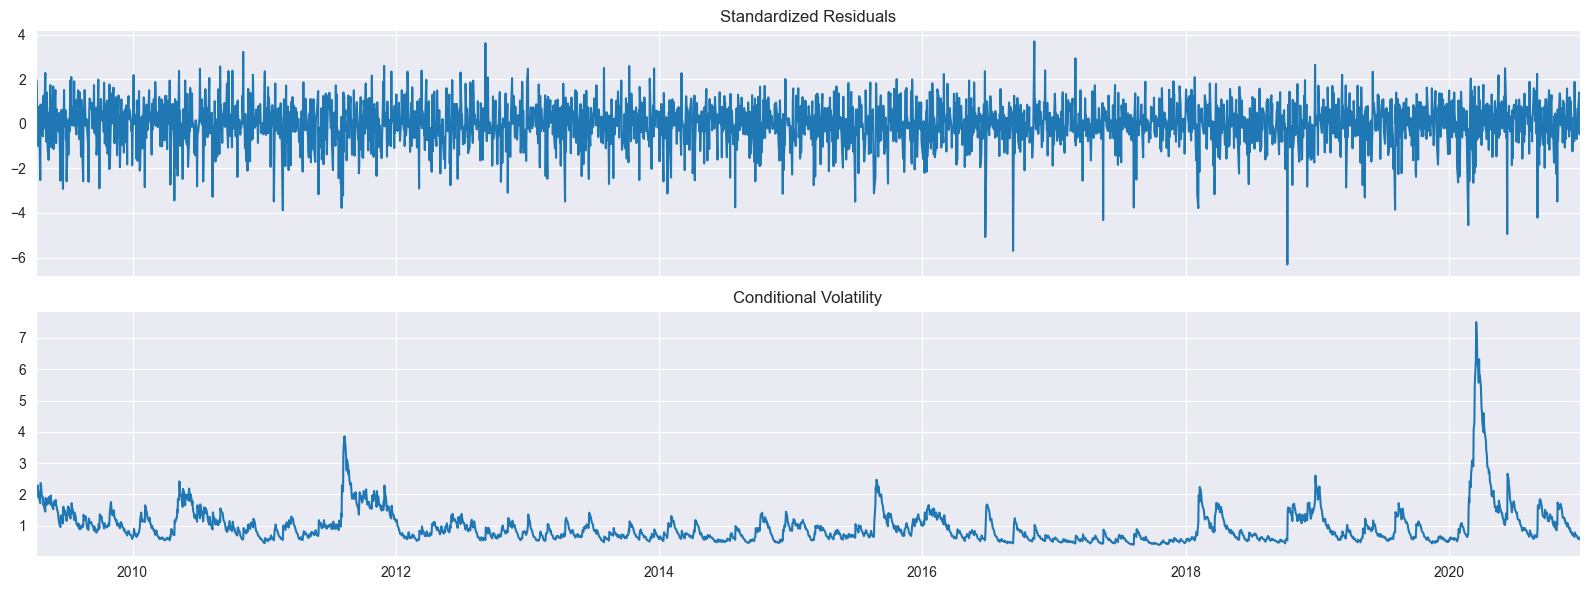

In [58]:
model = arch_model(returns,dist='skewstudent', vol = 'Garch', p=1, q=1)
result = model.fit(disp='off')
figure, axes = plt.subplots(2,2,figsize = (16,6))
axes = axes.flatten()
result.summary()
resid = result.resid 
result.plot()
sns.histplot(resid,ax = axes[1],kde=True, bins = 30)
plot_acf(resid,ax = axes[2])
sm.qqplot(resid, line='45', ax= axes[3], fit=True)
for ax in range(4):
  axes[ax].set_xlabel(None)
  axes[ax].set_title(None)
plt.tight_layout()
plt.show()

In [59]:
split_date = returns.iloc[-test_size:].index
split_date[0]

Timestamp('2019-07-23 00:00:00')

<Axes: xlabel='Date'>

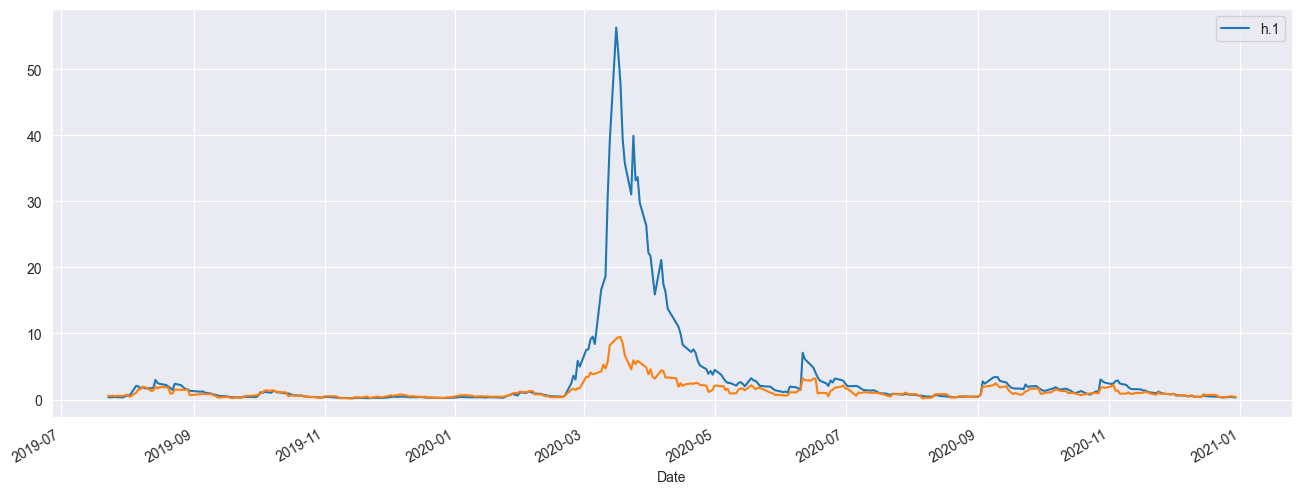

In [138]:
garch = arch_model(returns, mean='constant', 
                   vol = 'GARCH', p=1,o=0, q=1,
                   dist = 'skewstudent')
garch = garch.fit(disp='off')
garch.summary().tables[2]
forecast_garch = garch.forecast(start = split_date[0])
x=forecast_garch.variance
x.plot()
realized_vol[-365:].plot()

In [122]:
returns['2019-07-23']

0.6847482673755456

In [108]:
returns[:train_size]

Date
2009-04-07    -2.385
2009-04-08     1.178
2009-04-09     3.805
2009-04-13    0.2533
2009-04-14    -2.006
               ...  
2019-07-16   -0.3404
2019-07-17   -0.6531
2019-07-18    0.3582
2019-07-19   -0.6177
2019-07-22    0.2829
Name: Adj Close, Length: 2590, dtype: float64

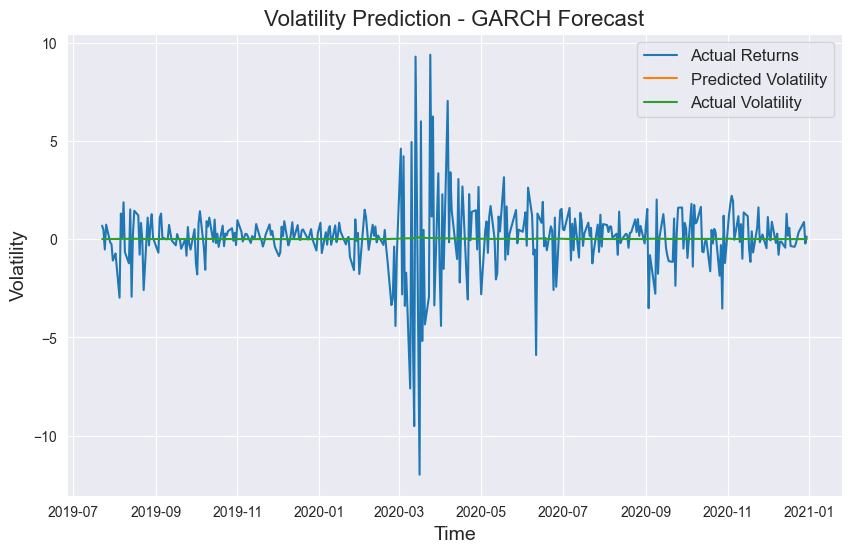

In [86]:
from arch import arch_model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have defined returns, split_date, and realized_vol_scaled

train_size = len(returns) - test_size

# Define and fit GARCH model
garch = arch_model(returns[:train_size], mean='constant', vol='GARCH', p=1, o=0, q=1, dist='skewstudent')
garch_fit = garch.fit(disp='off')

# Forecast volatility
forecast_garch = garch_fit.forecast(start=split_date[0])

# Extract forecasted values
forecasted_values = np.sqrt(forecast_garch.variance.iloc[-test_size:])


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(returns[-test_size:], label='Actual Returns')
plt.plot(forecasted_values, label='Predicted Volatility')
plt.plot(realized_vol_scaled[-365:], label='Actual Volatility')
plt.title('Volatility Prediction - GARCH Forecast', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Volatility', fontsize=14)
plt.legend(fontsize=12)
plt.show()


In [87]:
forecasted_values

,h.1
Date,


In [ ]:
import numpy as np
import yfinance as yf
import datetime as dt
from arch import arch_model
import matplotlib.pyplot as plt


def load_raw_data(ticker, start_date, end_date):
    price = yf.download(ticker, start_date, end_date)['Adj Close']
    ret = 100 * price.pct_change()[1:]
    return ret


def model_train(ret):
    global best_param
    bic_arch = []
    for p in range(1, 5):
        arch = arch_model(ret, mean='zero', vol='ARCH', p=p).fit(disp='off')
        bic_arch.append(arch.bic)
        if arch.bic == np.min(bic_arch):
            best_param = p
    arch = arch_model(ret, mean='zero', vol='ARCH', p=best_param).fit(disp='off')
    print(arch.summary())

    realized_vol = ret.rolling(5).std()
    n = 252
    split_date = ret.iloc[-n:].index
    forecast = arch.forecast(start=split_date[0])
    plt.figure(figsize=(10, 6))
    plt.plot(realized_vol / 100, label='Realized Volatility')
    plt.plot(forecast.variance.iloc[-len(split_date):] / 100, label='Volatility Prediction-ARCH')
    plt.title('Volatility Prediction with ARCH')
    plt.legend()
    plt.show()
    return arch


if __name__ == '__main__':
    ticker = '^GSPC'
    start_date = dt.datetime(2010, 1, 1)
    end_date = dt.datetime(2023, 7, 11)
    ret_ = load_raw_data(ticker, start_date, end_date)
    arch_model_ = model_train(ret_)
    forecasts = arch_model_.forecast(start=0)
    next_day_volatility = np.sqrt(forecasts.variance.iloc[-1, :] / 100)
    print(next_day_volatility)
